# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.9321200335462354
 0.7529714656826643
 0.8355528652141102
 0.4282023219575979
 0.6747199582215466
 0.2528010046350939
 0.5975492970899317
 0.10947088379184189
 0.7602449425636315
 0.02502201526865999
 0.5921227964026381
 0.7941094248594827
 0.48663424785230425
 ⋮
 0.13494265911903014
 0.5069963907311918
 0.91117964674939
 0.62053984177658
 0.8059655132285295
 0.4726435131384841
 0.39011196720118413
 0.09966660870001975
 0.8916540365509511
 0.628739963674958
 0.49163976113852326
 0.7184168085707174

In [2]:
sum(a)

4.9999891446793005e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.004994 seconds (1 allocation: 16 bytes)


4.9999891446793005e6

In [4]:
@time sum(a)

  0.005915 seconds (1 allocation: 16 bytes)


4.9999891446793005e6

In [5]:
@time sum(a)

  0.005409 seconds (1 allocation: 16 bytes)


4.9999891446793005e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/repos/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/repos/julia/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

4.999989144679923e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [ ]:
c_sum(a) - sum(a)  

In [ ]:
≈  # alias for the `isapprox` function

In [ ]:
?isapprox

We can now benchmark the C code directly from Julia:

In [12]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 420 samples with 1 evaluation.
 Range (min … max):  11.332 ms …  14.711 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.854 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.896 ms ± 324.810 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▃▇▃▇▄███▅▂▂                                           
  ▂▁▁▁▄▄█████████████▇▄▆▄▆▄▄▃▃▃▂▂▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂ ▄
  11.3 ms         Histogram: frequency by time         13.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [13]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.331579 msec


In [14]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 11.3316

In [15]:
using Plots
gr()

Plots.GRBackend()

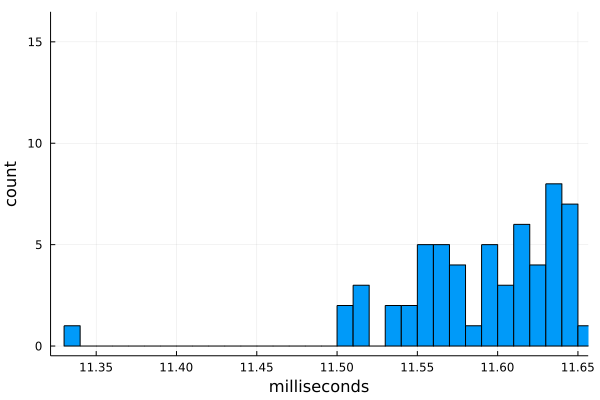

In [16]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [17]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [18]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1178 samples with 1 evaluation.
 Range (min … max):  3.890 ms …   8.486 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.146 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.226 ms ± 336.998 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▆▇▇█▅▇▂▃▂▂ ▃▂                                              
  ▇██████████████▇█▇█▆██▇▆█▇▆▅▅▆▄▅▅▃▅▃▄▃▃▂▃▂▂▃▃▂▁▂▁▃▁▁▁▁▂▁▂▁▂ ▄
  3.89 ms         Histogram: frequency by time        5.24 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [19]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

3.89006

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [20]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/repos/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/repos/julia/Introduction-to-Julia/Manifest.toml`


In [21]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [22]:
pysum(a)

4.999989144679923e6

In [23]:
pysum(a) ≈ sum(a)

true

In [24]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  559.150 ms … 568.508 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     564.975 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   564.122 ms ±   3.347 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                  ▁           ▁     ▁ ▁     ▁         ▁    ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  559 ms           Histogram: frequency by time          569 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [25]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 11.3316
  "Python built-in" => 559.15
  "C -ffast-math"   => 3.89006

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [26]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/repos/julia/Introduction-to-Julia/Project.toml`
  No Changes to `~/repos/julia/Introduction-to-Julia/Manifest.toml`


In [27]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/alex/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



In [28]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1059 samples with 1 evaluation.
 Range (min … max):  4.340 ms …   8.962 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.598 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.704 ms ± 374.404 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▃█▇▆█▄▂▃▂          ▁                                        
  ▅█████████▇█▇▆▇▇▅█▅▇█▆██▅▇▅▄▄▄▅▄▃▄▃▃▃▃▁▂▃▂▃▃▂▃▁▂▂▂▁▁▁▃▁▂▂▁▂ ▄
  4.34 ms         Histogram: frequency by time        5.81 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [29]:
numpy_sum(a)

4.999989144679293e6

In [30]:
numpy_sum(a) ≈ sum(a)

true

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 11.3316
  "Python numpy"    => 4.34048
  "Python built-in" => 559.15
  "C -ffast-math"   => 3.89006

# 5. Python, hand-written 

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f8bf84021f0>

In [33]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  694.873 ms … 712.706 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     700.159 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   700.843 ms ±   5.463 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁        ▁    ▁▁     █                                   ▁  
  █▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁██▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  695 ms           Histogram: frequency by time          713 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [34]:
sum_py(a)

4.999989144679923e6

In [35]:
sum_py(a) ≈ sum(a)

true

In [36]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 11.3316
  "Python numpy"        => 4.34048
  "Python hand-written" => 694.873
  "Python built-in"     => 559.15
  "C -ffast-math"       => 3.89006

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [37]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [38]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1003 samples with 1 evaluation.
 Range (min … max):  4.358 ms …   8.849 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.938 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.965 ms ± 322.188 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                      ▂▃▂▃▂▇▅█▅▄▅▂▃▂▃▁                         
  ▂▁▂▂▁▃▂▄▃▃▄▂▃▄▅▄▆▆▆▇██████████████████▆▆▅▄▅▃▃▄▄▄▂▃▃▃▂▂▁▂▂▁▂ ▄
  4.36 ms         Histogram: frequency by time        5.57 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [39]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 11.3316
  "Python numpy"        => 4.34048
  "Python hand-written" => 694.873
  "Python built-in"     => 559.15
  "Julia built-in"      => 4.358
  "C -ffast-math"       => 3.89006

# 7. Julia (hand-written) 

In [40]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [41]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 413 samples with 1 evaluation.
 Range (min … max):  11.618 ms …  14.016 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.031 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.081 ms ± 275.341 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▂▃▄▄█ ▂ ▄▅ ▁                                         
  ▂▂▃▅▅▆▅█▅███████▇████▅▅▆▄▄▄▄▄▂▃▅▄▃▃▂▁▁▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂ ▄
  11.6 ms         Histogram: frequency by time         13.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 11.3316
  "Python numpy"        => 4.34048
  "Julia hand-written"  => 11.6181
  "Python hand-written" => 694.873
  "Python built-in"     => 559.15
  "Julia built-in"      => 4.358
  "C -ffast-math"       => 3.89006

# 8. Julia (hand-written w. simd) 

In [43]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [44]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 963 samples with 1 evaluation.
 Range (min … max):  4.529 ms …   9.749 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.160 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.168 ms ± 289.997 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                              ▁▂▄▄▅█▁▄▄▄▃▂                     
  ▂▂▂▂▂▃▂▂▃▂▃▂▃▃▃▃▃▃▄▄▄▃▃▅▇█▆███████████████▇▅▄▅▄▄▃▃▃▃▃▂▃▂▁▃▃ ▄
  4.53 ms         Histogram: frequency by time        5.63 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
mysum_simd(a)

4.999989144679302e6

In [46]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.52858
  "C"                       => 11.3316
  "Python numpy"            => 4.34048
  "Julia hand-written"      => 11.6181
  "Python hand-written"     => 694.873
  "Python built-in"         => 559.15
  "Julia built-in"          => 4.358
  "C -ffast-math"           => 3.89006

# Summary

In [47]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............3.9
Python numpy................4.3
Julia built-in..............4.4
Julia hand-written simd.....4.5
C..........................11.3
Julia hand-written.........11.6
Python built-in...........559.2
Python hand-written.......694.9
